# Ames housing: penalised regression with h2o

Contents
 - start
 - basis functions
 - regression with h2o
 - save model and save predictions
 
Notes
 - ** h2o does not need onehot for hccv's **

Sources:
 - 

Copyright (C) 2018 Alan Chalk  
Please do not distribute or publish without permission.

## Start_.

**packages**

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch

import matplotlib.pyplot as plt
%matplotlib inline

**Directories and paths**

In [2]:
# Set directories
print(os.getcwd())
dirRawData = "../input/"
dirPData =   "../PData/"

/home/jovyan/2020/Projects/AmesHousing/PCode


**Functions**

In [3]:
def fn_MAE(actuals, predictions):
    return np.round(np.mean(np.abs(predictions - actuals)))

def fn_RMSE(actuals, predictions):
    return np.round(np.sqrt(np.mean((predictions - actuals)**2)))

**Load data**

In [4]:
# load df_all (use the none one-hot version)
#df_all = pd.read_hdf(dirPData + '02_df_all.h5', 'df_all')
f_name = dirPData + '02_df.pickle'

with (open(f_name, "rb")) as f:
    dict_ = pickle.load(f)

df_all = dict_['df_all']

del f_name, dict_

In [5]:
# load the variables information
f_name = dirPData + '02_vars.pickle'
with open(f_name, "rb") as f:
    dict_ = pickle.load(f)
    
var_dep = dict_['var_dep']
vars_ind_numeric = dict_['vars_ind_numeric']
vars_ind_categorical = dict_['vars_ind_categorical']
vars_ind_onehot = dict_['vars_ind_onehot']

del dict_

In [6]:
idx_train  = df_all['fold'].isin(range(6))
idx_val    = df_all['fold'].isin([6, 7])
idx_design = df_all['fold'].isin(range(8))
idx_test   = df_all['fold'].isin([8, 9])

**Prepare basis functions**

In [7]:
# do this only for truly continuous variables
# (this is not necessarily "right" - but just quicker to code ...)
# using >8 made sklearn crash - but h2o is fine with it
vars_ind_tospline = df_all[vars_ind_numeric].columns[(df_all[vars_ind_numeric].nunique() > 8)].tolist()

In [8]:
def fn_tosplines(x):
    x = x.values
    # hack: remove zeros to avoid issues where lots of values are zero
    x_nonzero = x[x != 0]
    ptiles = np.percentile(x_nonzero, [10, 20, 40, 60, 80, 90])
    ptiles = np.unique(ptiles)
    print(var, ptiles)
    df_ptiles = pd.DataFrame({var: x})
    for idx, ptile in enumerate(ptiles):
        df_ptiles[var + '_' + str(idx)] = np.maximum(0, x - ptiles[idx])
    return(df_ptiles)

Now update df_all with splines / basis functions

In [9]:
for var in vars_ind_tospline:
    df_ptiles = fn_tosplines(df_all[var])
    df_all.drop(columns=[var], inplace=True)
    vars_ind_numeric.remove(var)
    df_all = pd.concat([df_all, df_ptiles], axis=1, sort=False)
    vars_ind_numeric.extend(df_ptiles.columns.tolist())

lot_area [ 4800.   7000.   8727.6 10140.  12178.4 14248.5]
overall_qual [5. 6. 7. 8.]
overall_cond [5. 6. 7.]
year_built [1925.  1947.2 1965.  1984.  2003.  2006. ]
year_remod_add [1950. 1960. 1978. 1998. 2005. 2006.]
bsmtfin_sf_1 [ 176.   300.   504.   697.   954.6 1187.6]
bsmtfin_sf_2 [ 96. 149. 276. 449. 668. 850.]
bsmt_unf_sf [ 148.   234.   410.2  634.   927.  1251.2]
total_bsmt_sf [ 650.3  768.   920.  1099.  1398.  1614. ]
x1st_flr_sf [ 744.1  847.   997.  1180.6 1479.  1670. ]
x2nd_flr_sf [ 472.   554.4  694.4  814.6  976.8 1157.4]
low_qual_fin_sf [ 80.  136.  290.8 394.  487.2 516.3]
gr_liv_area [ 924.  1064.2 1326.  1558.  1836.  2139.8]
totrms_abvgrd [5. 6. 7. 8.]
garage_area [270.  314.6 441.  525.  625.  767.2]
wood_deck_sf [ 85.  113.4 150.  192.  263.6 329.3]
open_porch_sf [ 27.  35.  50.  78. 122. 172.]
enclosed_porch [ 42.7  77.  114.8 158.  211.6 244. ]
x3ssn_porch [126.  145.2 168.  208.  253.  321.2]
screen_porch [109.5 123.  160.  189.  224.  265.5]
pool_area [228.

In [10]:
vars_ind = vars_ind_categorical + vars_ind_numeric

In [11]:
# for convenience store dependent variable as y
y = df_all[var_dep].values.ravel()

### "elastic net" regression

**start h2o**

In [12]:
h2o.init(port=54321)
#h2o.connect()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_212"; OpenJDK Runtime Environment (build 1.8.0_212-8u212-b03-0ubuntu1.18.04.1-b03); OpenJDK 64-Bit Server VM (build 25.212-b03, mixed mode)
  Starting server from /opt/conda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmporpe_4la
  JVM stdout: /tmp/tmporpe_4la/h2o_jovyan_started_from_python.out
  JVM stderr: /tmp/tmporpe_4la/h2o_jovyan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,1 year and 25 days !!!
H2O cluster name:,H2O_from_python_jovyan_rn6htr
H2O cluster total nodes:,1
H2O cluster free memory:,443 Mb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


**Load data into h2o**

In [13]:
h2o_df_all = h2o.H2OFrame(df_all[vars_ind + var_dep + ['fold']],
                          destination_frame = 'df_all')

Parse progress: |█████████████████████████████████████████████████████████| 100%


Notes
 - h2o_df_all is a "handle" to the object stored in the h2o JVM
 - Similar attributes to pandas dataframe, but not the same
 - pandas uses "dtypes"
 - important to check the types for each column are correct

In [14]:
h2o_df_all.head(5)

ms_subclass,ms_zoning,street,alley,lot_shape,land_contour,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,heating,heating_qc,central_air,electrical,kitchen_qual,functional,fireplace_qu,garage_type,garage_finish,garage_qual,garage_cond,paved_drive,fence,misc_feature,sale_type,sale_condition,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,fireplaces,garage_cars,yr_sold,lot_area,lot_area_0,lot_area_1,lot_area_2,lot_area_3,lot_area_4,lot_area_5,overall_qual,overall_qual_0,overall_qual_1,overall_qual_2,overall_qual_3,overall_cond,overall_cond_0,overall_cond_1,overall_cond_2,year_built,year_built_0,year_built_1,year_built_2,year_built_3,year_built_4,year_built_5,year_remod_add,year_remod_add_0,year_remod_add_1,year_remod_add_2,year_remod_add_3,year_remod_add_4,year_remod_add_5,bsmtfin_sf_1,bsmtfin_sf_1_0,bsmtfin_sf_1_1,bsmtfin_sf_1_2,bsmtfin_sf_1_3,bsmtfin_sf_1_4,bsmtfin_sf_1_5,bsmtfin_sf_2,bsmtfin_sf_2_0,bsmtfin_sf_2_1,bsmtfin_sf_2_2,bsmtfin_sf_2_3,bsmtfin_sf_2_4,bsmtfin_sf_2_5,bsmt_unf_sf,bsmt_unf_sf_0,bsmt_unf_sf_1,bsmt_unf_sf_2,bsmt_unf_sf_3,bsmt_unf_sf_4,bsmt_unf_sf_5,total_bsmt_sf,total_bsmt_sf_0,total_bsmt_sf_1,total_bsmt_sf_2,total_bsmt_sf_3,total_bsmt_sf_4,total_bsmt_sf_5,x1st_flr_sf,x1st_flr_sf_0,x1st_flr_sf_1,x1st_flr_sf_2,x1st_flr_sf_3,x1st_flr_sf_4,x1st_flr_sf_5,x2nd_flr_sf,x2nd_flr_sf_0,x2nd_flr_sf_1,x2nd_flr_sf_2,x2nd_flr_sf_3,x2nd_flr_sf_4,x2nd_flr_sf_5,low_qual_fin_sf,low_qual_fin_sf_0,low_qual_fin_sf_1,low_qual_fin_sf_2,low_qual_fin_sf_3,low_qual_fin_sf_4,low_qual_fin_sf_5,gr_liv_area,gr_liv_area_0,gr_liv_area_1,gr_liv_area_2,gr_liv_area_3,gr_liv_area_4,gr_liv_area_5,totrms_abvgrd,totrms_abvgrd_0,totrms_abvgrd_1,totrms_abvgrd_2,totrms_abvgrd_3,garage_area,garage_area_0,garage_area_1,garage_area_2,garage_area_3,garage_area_4,garage_area_5,wood_deck_sf,wood_deck_sf_0,wood_deck_sf_1,wood_deck_sf_2,wood_deck_sf_3,wood_deck_sf_4,wood_deck_sf_5,open_porch_sf,open_porch_sf_0,open_porch_sf_1,open_porch_sf_2,open_porch_sf_3,open_porch_sf_4,open_porch_sf_5,enclosed_porch,enclosed_porch_0,enclosed_porch_1,enclosed_porch_2,enclosed_porch_3,enclosed_porch_4,enclosed_porch_5,x3ssn_porch,x3ssn_porch_0,x3ssn_porch_1,x3ssn_porch_2,x3ssn_porch_3,x3ssn_porch_4,x3ssn_porch_5,screen_porch,screen_porch_0,screen_porch_1,screen_porch_2,screen_porch_3,screen_porch_4,screen_porch_5,pool_area,pool_area_0,pool_area_1,pool_area_2,pool_area_3,pool_area_4,pool_area_5,misc_val,misc_val_0,misc_val_1,misc_val_2,misc_val_3,misc_val_4,mo_sold,mo_sold_0,mo_sold_1
MS_20,RL,Pave,DoesNotHaveOne,IR1,Lvl,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Plywood,Stone,TA,TA,CBlock,TA,Gd,Gd,BLQ,Unf,GasA,Fa,Y,SBrkr,TA,Typ,Gd,Attchd,Fin,TA,TA,P,DoesNotHaveOne,DoesNotHaveOne,WD,Normal,1,0,1,0,3,1,2,2,2010,31770,26970,24770,23042.4,21630,19591.6,17521.5,6,1,0,0,0,5,0,0,0,1960,35,12.8,0,0,0,0,1960,10,0,0,0,0,0,639,463,339,135,0,0,0,0,0,0,0,0,0,0,441,293,207,30.8,0,0,0,1080,429.7,312,160,0,0,0,1656,911.9,809,659,475.4,177,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1656,732,591.8,330,98,0,0,7,2,1,0,0,528,258,213.4,87,3,0,0,210,125,96.6,60,18,0,0,62,35,27,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,2,1
MS_20,RH,Pave,DoesNotHaveOne,Reg,Lvl,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,TA,Typ,DoesNotHaveOne,Attchd,Unf,TA,TA,Y,MnPrv,DoesNotHaveOne,WD,Normal,0,0,1,0,2,1,0,1,2010,11622,6822,4622,2894.4,1482,0,0,5,0,0,0,0,6,1,0,0,1961,36,13.8,0,0,0,0,1961,11,1,0,0,0,0,468,292,168,0,0,0,0,144,48,0,0,0,0,0,270,122,36,0,0,0,0,882,231.7,114,0,0,0,0,896,151.9,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,896,0,0,0,0,0,0,5,0,0,0,0,730,460,415.4,289,205,105,0,140,55,26.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,120,10.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6

In [15]:
h2o_df_all[vars_ind_categorical].types

# h2o has correctly read in all vars_ind_categorical as enum, so no need to change
#for var in vars_ind_categorical:
#    h2o_df_all[var] = h2o_df_all[var].asfactor()

{'ms_subclass': 'enum',
 'ms_zoning': 'enum',
 'street': 'enum',
 'alley': 'enum',
 'lot_shape': 'enum',
 'land_contour': 'enum',
 'lot_config': 'enum',
 'land_slope': 'enum',
 'neighborhood': 'enum',
 'condition_1': 'enum',
 'condition_2': 'enum',
 'bldg_type': 'enum',
 'house_style': 'enum',
 'roof_style': 'enum',
 'roof_matl': 'enum',
 'exterior_1st': 'enum',
 'exterior_2nd': 'enum',
 'mas_vnr_type': 'enum',
 'exter_qual': 'enum',
 'exter_cond': 'enum',
 'foundation': 'enum',
 'bsmt_qual': 'enum',
 'bsmt_cond': 'enum',
 'bsmt_exposure': 'enum',
 'bsmtfin_type_1': 'enum',
 'bsmtfin_type_2': 'enum',
 'heating': 'enum',
 'heating_qc': 'enum',
 'central_air': 'enum',
 'electrical': 'enum',
 'kitchen_qual': 'enum',
 'functional': 'enum',
 'fireplace_qu': 'enum',
 'garage_type': 'enum',
 'garage_finish': 'enum',
 'garage_qual': 'enum',
 'garage_cond': 'enum',
 'paved_drive': 'enum',
 'fence': 'enum',
 'misc_feature': 'enum',
 'sale_type': 'enum',
 'sale_condition': 'enum'}

Notes
 - create boolean masks to index the df_all dataframe
 - is it necessary for them to be H2OFrame as done below?

In [16]:
idx_h2o_train  = h2o.H2OFrame(idx_train.astype('int').values)
idx_h2o_val    = h2o.H2OFrame(idx_val.astype('int').values)
idx_h2o_design = h2o.H2OFrame(idx_design.astype('int').values)
idx_h2o_test   = h2o.H2OFrame(idx_test.astype('int').values)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


###  Grid search

Notes
 - As discussed we need to use the data to "tune" the hyper-parameters ($\lambda$ and $\alpha$).
 - Here we will use the simplest approach; grid search.

Approach
 - Create a dataframe with all combinations of alpha and lambda that we want to run
 - Loop through all and find train / val combinations
 - Do we have to run through the whole grid?  For a given computing time budget can we do better?

Note
 - Grid search is implemented in sklearn and h2o.  We do it "manually" here just for clarity.


**lambda_search for alpha and lambda given an identity link**

Note
 - consider lists: ['A', 'B'] and ['x','y', 'z']
 - to create all possible combinations, we can use code below
 - (there is probably a much easier way!)

In [17]:
np.array(np.meshgrid(['A', 'B'], ['x','y', 'z'])).reshape(2, 6).T

array([['A', 'x'],
       ['B', 'x'],
       ['A', 'y'],
       ['B', 'y'],
       ['A', 'z'],
       ['B', 'z']], dtype='<U1')

In [18]:
[16. * 2.**-i for i in np.arange(15)] 

[16.0,
 8.0,
 4.0,
 2.0,
 1.0,
 0.5,
 0.25,
 0.125,
 0.0625,
 0.03125,
 0.015625,
 0.0078125,
 0.00390625,
 0.001953125,
 0.0009765625]

In [19]:
# create dataframe with combinations needed
# below for id link
lambda_opts = [16. * 2.**-i for i in np.arange(15)] #+ [0]
alpha_opts = [0, 0.5, 0.99]
n_iter = len(lambda_opts) * len(alpha_opts)
params = np.array(np.meshgrid(lambda_opts, alpha_opts)).reshape(2, n_iter).T


In [20]:
params[0:5, 0:2]

array([[16.,  0.],
       [ 8.,  0.],
       [ 4.,  0.],
       [ 2.,  0.],
       [ 1.,  0.]])

In [21]:
df_results = pd.DataFrame(params, columns = ['lambda', 'alpha'])
df_results['train_mae'] = np.nan
df_results['val_mae'] = np.nan
df_results['train_rmse'] = np.nan
df_results['val_rmse'] = np.nan


In [22]:
df_results.head()

,lambda,alpha,train_mae,val_mae,train_rmse,val_rmse
0,16.0,0.0,NaN,NaN,NaN,NaN
1,8.0,0.0,NaN,NaN,NaN,NaN
2,4.0,0.0,NaN,NaN,NaN,NaN
3,2.0,0.0,NaN,NaN,NaN,NaN
4,1.0,0.0,NaN,NaN,NaN,NaN


In [23]:
df_results.tail()

,lambda,alpha,train_mae,val_mae,train_rmse,val_rmse
40,0.015625,0.99,NaN,NaN,NaN,NaN
41,0.007812,0.99,NaN,NaN,NaN,NaN
42,0.003906,0.99,NaN,NaN,NaN,NaN
43,0.001953,0.99,NaN,NaN,NaN,NaN
44,0.000977,0.99,NaN,NaN,NaN,NaN


In [24]:
# the shape of the data
df_results.shape

(45, 6)

**TODO**

Fill in the code below and so create a loop which finds train and val MAE and MSE for each combination of  $\lambda$ and $\alpha$ inthe grid.

In [25]:

# loop through all and find train and val mae

h2o.no_progress()

for idx in range(df_results.shape[0]):
    if idx % 10 == 0:
        print(idx, 'of', df_results.shape[0])
        
    alpha = df_results.iloc[idx]['alpha']
    lambda_ = df_results.iloc[idx]['lambda']
    
    # create an instance of the H2OGeneralizedLinearEstimator() class, called model
    # alpha and lambda should be set to the values from the grid as above
    # family should be gaussian 'gaussian'
    # link should be 'identity'
    # We will explain link functions later on
    model=H2OGeneralizedLinearEstimator(alpha=alpha, 
                                        lambda_=lambda_,
                                        family='gaussian',
                                        link='identity'
                                        )
    # Train the model
    # The x variables should be vars_ind as define above
    # The target variable should be, as usual, 'saleprice'
    # The training frame should be the rows of h2o_df_all that the index idx_h2o_train defines
    model.train(x=vars_ind, 
                y='saleprice',
                training_frame=h2o_df_all[idx_h2o_train, :]
                #validation_frame=h2o_df_all[idx_h2o_val, :]
                )

    # Predict the model on train and val
    model_pred_train = model.predict(h2o_df_all[idx_h2o_train, :])
    model_pred_val   = model.predict(h2o_df_all[idx_h2o_val, :])

    # I find it convenient to store these values as a 1d np array
    model_pred_train = model_pred_train.as_data_frame().values.ravel()
    model_pred_val   = model_pred_val.as_data_frame().values.ravel()

    # Calculate train and cal mae and mse
    df_results['train_mae'].iloc[idx]  = fn_MAE(y[idx_train], model_pred_train)
    df_results['val_mae'].iloc[idx]    = fn_MAE(y[idx_val], model_pred_val)
    df_results['train_rmse'].iloc[idx] = fn_RMSE(y[idx_train], model_pred_train)
    df_results['val_rmse'].iloc[idx]   = fn_RMSE(y[idx_val], model_pred_val)

h2o.show_progress()

0 of 45
10 of 45
20 of 45
30 of 45
40 of 45


Get results for one of the alhpas and graph it

In [26]:
df_one_alpha = df_results[df_results['alpha'] == 0.99]
df_one_alpha

,lambda,alpha,train_mae,val_mae,train_rmse,val_rmse
30,16.000000,0.99,13497.0,14643.0,19614.0,21913.0
31,8.000000,0.99,12931.0,14350.0,18800.0,21622.0
32,4.000000,0.99,12473.0,14147.0,18088.0,21430.0
33,2.000000,0.99,12091.0,13982.0,17492.0,21299.0
34,1.000000,0.99,11808.0,13888.0,17022.0,21222.0
35,0.500000,0.99,11626.0,13969.0,16680.0,21213.0
36,0.250000,0.99,11519.0,14147.0,16453.0,21284.0
37,0.125000,0.99,11461.0,14344.0,16312.0,21417.0
38,0.062500,0.99,11436.0,14516.0,16229.0,21578.0
39,0.031250,0.99,11428.0,14649.0,16183.0,21735.0


Text(0, 0.5, 'Loss (MAE)')

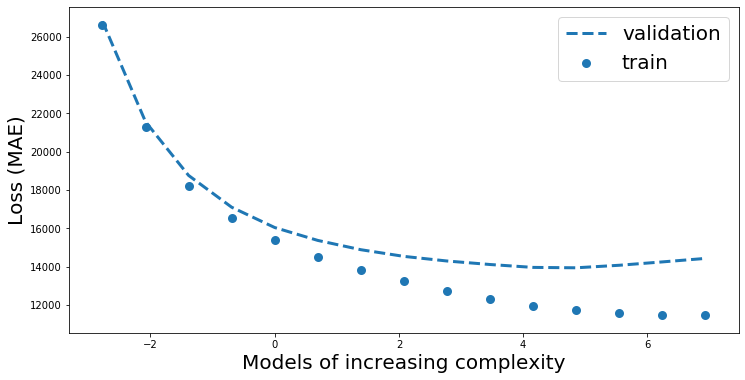

In [27]:
df_one_alpha = df_results[df_results['alpha'] == 0]

fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(1,1,1)
ax.plot(-np.log(df_one_alpha['lambda'].astype('float')), 
         df_one_alpha['val_mae'],
       linewidth=3, linestyle='--',
       label='validation')
ax.scatter(-np.log(df_one_alpha['lambda'].astype('float') + 1e-10), 
         df_one_alpha['train_mae'],
       linewidth=3, 
       label='train')

ax.legend(fontsize=20)
ax.set_xlabel('Models of increasing complexity', fontsize=20)
ax.set_ylabel('Loss (MAE)', fontsize=20)

**A view of the hyper-parameter search**

In [28]:
#df_score_history.head()
df_results.head()

,lambda,alpha,train_mae,val_mae,train_rmse,val_rmse
0,16.0,0.0,26590.0,26788.0,38568.0,39396.0
1,8.0,0.0,21258.0,21553.0,31296.0,32203.0
2,4.0,0.0,18222.0,18754.0,26813.0,27762.0
3,2.0,0.0,16531.0,17096.0,24082.0,25150.0
4,1.0,0.0,15384.0,16036.0,22300.0,23600.0


Text(0.5, 0, 'Models of increasing complexity')

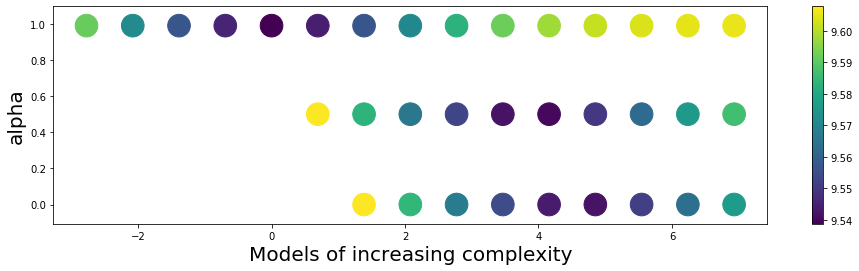

In [29]:
#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('viridis')

idx = df_results['val_mae'] < 15000
fig = plt.figure(figsize=[16,4])
ax = fig.add_subplot(1,1,1)
sc = ax.scatter(-np.log(df_results[idx]['lambda'])
           , df_results[idx]['alpha']
           , c=np.log(df_results[idx]['val_mae'])
           , cmap=cm
           , s=512)
plt.colorbar(sc)
ax.set_ylabel('alpha', fontsize=20)
ax.set_xlabel('Models of increasing complexity', fontsize=20)


**Another view of the hyper-parameter search**

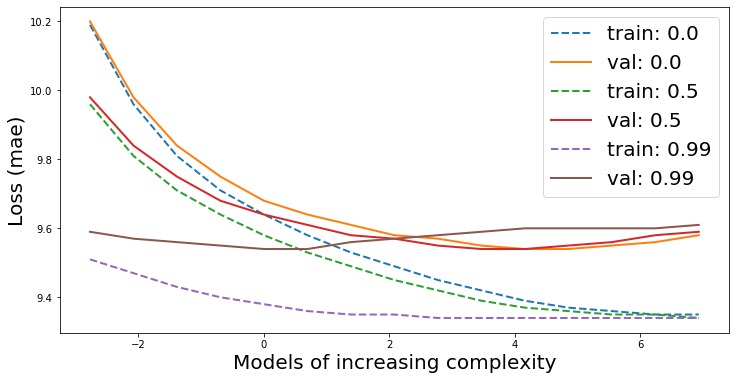

In [30]:
gb = df_results.groupby('alpha')

fig, ax = plt.subplots(figsize=[12, 6])

for key, group in gb:
    ax.plot(-np.log(group['lambda']), 
             np.round(np.log(group['train_mae']), 2),
             label='train: ' + str(key),
             linestyle='--',
             linewidth=2)
    ax.plot(-np.log(group['lambda']), 
             np.round(np.log(group['val_mae']), 2),
             label='val: ' + str(key),
             linewidth=2)

ax.set_ylabel('Loss (mae)', fontsize=20)
ax.set_xlabel('Models of increasing complexity', fontsize=20)
ax.legend(fontsize=20)

**identity link model on best alpha and lambda**

**TODO**
 - From above find the best alpha-lambda combination
 - Using the combined train and val data fit one last model
 - Predict on train, val and test and find the MAE and MSE

In [31]:
idx_best = df_results['val_mae'].idxmin()
bst_alpha = df_results.iloc[idx_best]['alpha']
bst_lambda = df_results.iloc[idx_best]['lambda']
print('best:\n', 'alpha:', bst_alpha, '\n lambda', bst_lambda)
# The best parameters are
#
#
# These are typed in below to avoid having to run the grid search each time

best:
 alpha: 0.99 
 lambda 1.0


In [32]:
h2o.no_progress()

glm_bst=H2OGeneralizedLinearEstimator(alpha=0.99 # bst_alpha 
                                  , lambda_= 2 # bst_lambda 
                                  , family='gaussian'
                                  , link='identity'
                                  )
glm_bst.train(x=vars_ind, 
          y='saleprice',
          training_frame=h2o_df_all[idx_h2o_design, :]
          )


bst_pred_train = glm_bst.predict(h2o_df_all[idx_h2o_train, :])
bst_pred_val   = glm_bst.predict(h2o_df_all[idx_h2o_val, :])
bst_pred_test  = glm_bst.predict(h2o_df_all[idx_h2o_test, :])

bst_pred_train = bst_pred_train.as_data_frame().values.ravel()
bst_pred_val   = bst_pred_val.as_data_frame().values.ravel()
bst_pred_test  = bst_pred_test.as_data_frame().values.ravel()

print('train error', fn_MAE(y[idx_train], bst_pred_train))
print('val error',   fn_MAE(y[idx_val], bst_pred_val))
print('test error',  fn_MAE(y[idx_test], bst_pred_test))

h2o.show_progress()

# AC run gives
#train error 11950.0
#val error 12077.0
#test error 13667.0
# And these should be reproduced by this code

train error 12227.0
val error 12378.0
test error 13675.0


**Save the model**

In [ ]:
glm_bst_path = h2o.save_model(model=glm_bst, path=dirPData, force=True)

In [ ]:
glm_bst_path

In [ ]:
glm_bst = h2o.load_model(path = glm_bst_path)

**Create and store predictions for future use**

In [ ]:
df_predictions = df_all[['order', 'pid']].copy()

In [ ]:
df_predictions['m_1a'] = glm_bst.predict(h2o_df_all).as_data_frame().values.ravel()

In [ ]:
dict_ = {'df_predictions': df_predictions,
         'm_1a': 'logistic regression, elastic net, saved as glm_best',
         'm_1a_path': glm_bst_path}

In [ ]:
#store = pd.HDFStore(dirPData + 'predictions.h5')
#df_predictions.to_hdf(store, 'df_predictions')
#store.close()
f_name = dirPData + 'dict_predictions.pickle'

with open(f_name, "wb") as f:
    pickle.dump(dict_, f)
    
del f_name, dict_

**View standarised coefficient magnitudes**

 - variable importance

In [ ]:
glm_bst.std_coef_plot(num_of_features=10)

**example of a result of using splines**

living area

In [ ]:
#gr_liv_area
df_gr = df_all[['saleprice' ,'gr_liv_area']].groupby('gr_liv_area').agg(np.mean)
df_gr.reset_index(inplace=True)    
df_gr.head()

In [ ]:
fig = plt.figure(figsize= (12, 6))
ax1 = fig.add_subplot(1, 1, 1)

ax1.scatter(df_gr['gr_liv_area'], 
            df_gr['saleprice'],
            s = 64)
ax1.set_xlabel('gr_liv_area', fontsize=20)
ax1.set_ylabel('sale price', fontsize=20)
#ax1.set_xlim([500, 3000])
#ax1.set_ylim([50000, 400000])

In [ ]:
# add splines
for idx, ptile in enumerate([ 924.,  1064.2, 1326.,  1558.,  1836.,  2139.8]):
    df_gr['gr_liv_area_' + str(idx)] = np.maximum(0, df_gr['gr_liv_area'] - ptile)


In [ ]:
#  get coefficients
df_coefficients = pd.DataFrame(model.coef(), index=['coefficient']).T
df_coefficients.reset_index(inplace=True)
df_coefficients.rename(columns={'index':'feature'}, inplace=True)
#idx_row = df_coefficients['feature'].str.startswith('gr')
idx_row = df_coefficients['feature'].str.startswith('gr_liv_area')
df_coefficients[idx_row]


In [ ]:
idx_basis = ['gr_liv_area', 'gr_liv_area_0', 'gr_liv_area_1', 'gr_liv_area_2', 'gr_liv_area_3',
            'gr_liv_area_4', 'gr_liv_area_5']
df_gr['linear_predictor'] = df_gr[idx_basis].values.dot(df_coefficients[idx_row]['coefficient'].values)

df_gr['saleprice'] = df_gr['saleprice'] * df_gr['linear_predictor'].median() / df_gr['saleprice'].median()

In [ ]:
fig = plt.figure(figsize= (12, 6))
ax1 = fig.add_subplot(1, 1, 1)

ax1.scatter(df_gr['gr_liv_area'], 
            df_gr['saleprice'],
            s=64)
ax1.plot(df_gr['gr_liv_area'], 
         df_gr['linear_predictor'],
        c='red',
        linewidth=3)
ax1.set_xlabel('gr_liv_area', fontsize=20)
ax1.set_ylabel('contribution to linear predictor', fontsize=20)
#ax1.set_xlim([500, 3000])
#ax1.set_ylim([0, 1])

In [ ]:
h2o.cluster().shutdown()